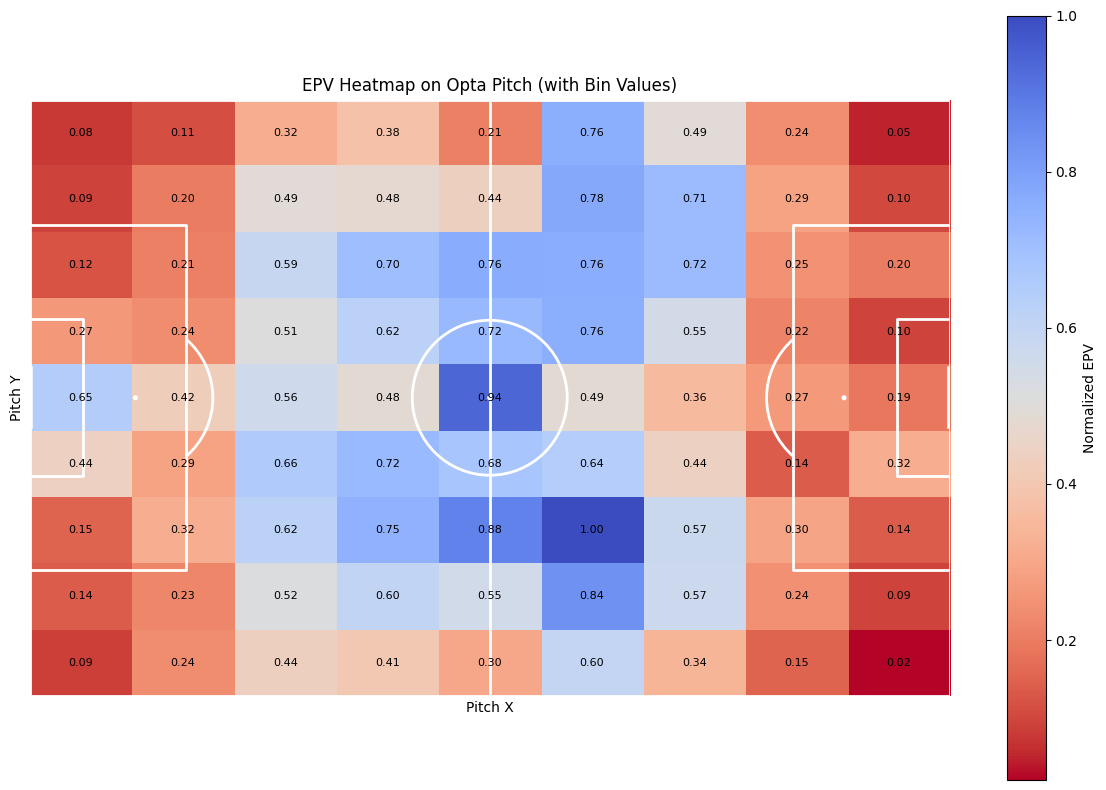

In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Define grid size and bins for pitch areas (split pitch into smaller cells)
grid_size = 10  # Adjust the grid size if needed
x_bins = np.linspace(0, 100, grid_size)  # Opta pitch width (scaled to 100)
y_bins = np.linspace(0, 100, grid_size)  # Opta pitch height (scaled to 100)

# Calculate the 2D histogram of EPV values based on the position of the event's end (end_x, end_y)
# Note that X_test["y"] corresponds to the height (y), and X_test["x"] corresponds to the width (x)
heatmap, xedges, yedges = np.histogram2d(
    X_test["x"], X_test["y"], bins=[x_bins, y_bins], weights=X_test["epv"]
)

# Normalize the heatmap to a 0-1 range for better color mapping
heatmap = heatmap / np.max(heatmap)

# Create a Pitch object with Opta pitch layout
pitch = Pitch(pitch_type='opta', pitch_color='green', line_color='white')

# Create the figure and axis with constrained layout
fig, ax = pitch.draw(figsize=(12, 8), constrained_layout=True)

# Plot the heatmap using imshow for better aspect control
im = ax.imshow(
    heatmap.T,          # Transpose so rows=Y, columns=X for imshow
    cmap="coolwarm_r",  # Reversed color map: warmer colors for higher values
    extent=[0, 100, 0, 100],  # Match the Opta pitch bounds (0-100 for x and y)
    origin="lower",     # Ensure the origin starts from the bottom-left
)

# Adjust the aspect ratio manually to reflect a football pitch's dimensions (105x68)
ax.set_aspect(68 / 105)  # y-axis (height) will correspond to the 105m width

# Adjust the x and y axis limits to match the pitch dimensions
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

# Reverse the y-axis to match the typical football pitch view
ax.invert_yaxis()
# ax.invert_xaxis()  # Uncomment if you want to flip horizontally as well

# Annotate each bin with its EPV value
# heatmap.shape = (len(x_bins)-1, len(y_bins)-1)
# i corresponds to x-bins, j to y-bins
for i in range(len(xedges) - 1):
    for j in range(len(yedges) - 1):
        # Calculate bin center
        x_center = (xedges[i] + xedges[i + 1]) / 2
        y_center = (yedges[j] + yedges[j + 1]) / 2
        
        # Get the EPV value from the heatmap
        # Note: Because of the transpose in imshow, we index heatmap as [i, j]
        val = heatmap[i, j]
        
        # Optionally skip printing zero or very small values
        # if val < 0.001:
        #     continue
        
        # Add text at the center of the bin
        ax.text(
            x_center, y_center,
            f"{val:.2f}",         # Round to 2 decimal places
            color="black",        # Choose 'white' or 'black' depending on visibility
            ha="center", va="center", fontsize=8
        )

# Add title and labels
plt.title("EPV Heatmap on Opta Pitch (with Bin Values)")
plt.xlabel("Pitch X")
plt.ylabel("Pitch Y")

# Show the colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical')
cbar.set_label("Normalized EPV")

# Show the plot
plt.show()


In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# 1. Load data from Excel
df = pd.read_excel("BM2425.xlsx")

# 2. Exclude rows where Corner == 1, FK == 1, or ThrowIn == 1
df = df[~((df["Corner"] == 1) | (df["FK"] == 1) | (df["ThrowIn"] == 1))]

# 3. Add calculated features
df["distance_to_goal"] = np.sqrt((105 - df["endX"])**2 + (34 - df["endY"])**2)
df["angle_to_goal"] = np.arctan2(34 - df["endY"], 105 - df["endX"])

# 4. Encode targets based on rules
df["goal"] = (df["typeId"] == 16).astype(int)
df["loss"] = (df["typeId"] == 9).astype(int)
df["possession_continuation"] = ((df["typeId"] == 1) & (df["outcome"] == 1)).astype(int)

# 5. Additional encoded columns
df["TakeO"] = (df["typeId"] == 3).astype(int)
df["Shot"] = ((df["typeId"] == 13) | (df["typeId"] == 14) | (df["typeId"] == 15)).astype(int)
df["Tackle"] = ((df["typeId"] == 7) & (df["outcome"] == 1)).astype(int)
df["Ball_recovery"] = (df["typeId"] == 49).astype(int)
df["Assists"] = (df["Assist"] == 1).astype(int)
df["2nd_Assists"] = (df["2nd Assist"] == 1).astype(int)

# 6. Define features and targets
features = [
    "x", "y", "endX", "endY", 
    "distance_to_goal", "angle_to_goal",
    "TakeO", "Shot", "Tackle", "Ball_recovery", 
    "Assists", "2nd_Assists"
]
targets = [
    "goal", "possession_continuation", "loss",
    "TakeO", "Shot", "Tackle", 
    "Ball_recovery", "Assists", "2nd_Assists"
]

# 7. Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[targets], test_size=0.2, random_state=42
)

# 8. Train RandomForest models for each outcome
models = {}
for target in targets:
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train[target])
    models[target] = clf

# 9. Predict probabilities using multiple simulations for stability
n_simulations = 1000
probs = {target: np.zeros(len(X_test)) for target in targets}

for _ in range(n_simulations):
    for target in targets:
        if len(models[target].classes_) == 1:
            # Single-class case
            probs[target] += 0
        else:
            # Accumulate probabilities for class==1
            probs[target] += models[target].predict_proba(X_test[features])[:, 1]

# 10. Average the probabilities over the simulations
for target in targets:
    probs[target] /= n_simulations
    # Store them in X_test
    X_test[f"{target}_prob"] = probs[target]

# 11. Define weights for each metric's contribution to EPV
weights = {
    "goal_prob": 1.5,
    "loss_prob": -1.0,
    "possession_continuation_prob": 0.8,
    "TakeO_prob": 0.5,
    "Shot_prob": 1.2,
    "Tackle_prob": 0.4,
    "Ball_recovery_prob": 0.6,
    "Assists_prob": 1.0,
    "2nd_Assists_prob": 0.7
}

# 12. Calculate a weighted EPV
X_test["epv"] = sum(
    weights[f"{target}_prob"] * X_test[f"{target}_prob"]
    for target in targets
)

# 13. Merge the epv (and probabilities) back into df
#     Initialize columns in df so we can fill them in
for target in targets:
    df[f"{target}_prob"] = np.nan
df["epv"] = np.nan

# Update rows that are part of X_test
df.loc[X_test.index, "epv"] = X_test["epv"]
for target in targets:
    df.loc[X_test.index, f"{target}_prob"] = X_test[f"{target}_prob"]

# 14. Create a final DataFrame of columns in the desired order
final_columns = [
    "playerName",  # Add playerName to ensure uniqueness
    "goal_prob",
    "possession_continuation_prob",
    "loss_prob",
    "TakeO_prob",
    "Shot_prob",
    "Tackle_prob",
    "Ball_recovery_prob",
    "Assists_prob",
    "2nd_Assists_prob",
    "epv",
]
final_df = df[final_columns].copy()  # This includes all rows (for all players)

# 15. Save to a single Excel file
output_filename = "AllPlayers_Probabilities_and_EPV.xlsx"
final_df.to_excel(output_filename, index=True)  # keep the original row indices

print(f"Saved final table to '{output_filename}'. Here is a preview:")
print(final_df.head(10))

# Ensure 'playerName' is treated as a string and handle NaN values
df["playerName"] = df["playerName"].fillna("Unknown").astype(str)

# Save separate files for each unique player with unique playerName and probabilities
unique_players = df["playerName"].unique()

for player in unique_players:
    player_df = df[df["playerName"] == player]
    player_final_df = player_df[["playerName"] + final_columns[1:]].drop_duplicates(subset="playerName").copy()

    # Construct a filename for each player
    player_filename = f"{player.replace(' ', '_')}_Probabilities_and_EPV.xlsx"

    # Save the player's data to an Excel file
    player_final_df.to_excel(player_filename, index=False)  # exclude the index for clean output

    print(f"Saved probabilities and EPV table for player '{player}' to '{player_filename}'.")

# 16. Calculate totals per player for all actions
totals_per_player = df.groupby("playerName")[
    ["goal", "loss", "possession_continuation", "TakeO", "Shot", "Tackle", "Ball_recovery", "Assists", "2nd_Assists"]
].sum().reset_index()

# 17. Merge totals with probabilities and EPV
merged_df = pd.merge(final_df, totals_per_player, on="playerName", how="left")

# Save the merged data to a single Excel file
merged_filename = "AllPlayers_Combined_Probabilities_Totals_and_EPV.xlsx"
merged_df.to_excel(merged_filename, index=False)

print(f"Saved combined data for all players to '{merged_filename}'. Here is a preview:")
print(merged_df.head())


Saved final table to 'AllPlayers_Probabilities_and_EPV.xlsx'. Here is a preview:
    playerName  goal_prob  possession_continuation_prob  loss_prob  \
0          NaN        NaN                           NaN        NaN   
1          NaN        NaN                           NaN        NaN   
2          NaN        NaN                           NaN        NaN   
3          NaN        NaN                           NaN        NaN   
4   J. Musiala        NaN                           NaN        NaN   
5     M. Neuer        NaN                           NaN        NaN   
6   C. Zesiger        0.0                          0.31        0.0   
7     L. Majer        NaN                           NaN        NaN   
8   J. Kimmich        NaN                           NaN        NaN   
9  A. Pavlović        NaN                           NaN        NaN   

   TakeO_prob  Shot_prob  Tackle_prob  Ball_recovery_prob  Assists_prob  \
0         NaN        NaN          NaN                 NaN           NaN  

Saved probabilities and EPV table for player 'A. Losilla' to 'A._Losilla_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'E. Mašović' to 'E._Mašović_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'P. Drewes' to 'P._Drewes_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'T. Oermann' to 'T._Oermann_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'João Palhinha' to 'João_Palhinha_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'F. Passlack' to 'F._Passlack_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'J. Medić' to 'J._Medić_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'M. Wittek' to 'M._Wittek_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'C. Gamboa' to 'C._Gamboa_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'L. Daschner' to 'L._Daschner_Probabili

Saved probabilities and EPV table for player 'T. Puchacz' to 'T._Puchacz_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'M. Geschwill' to 'M._Geschwill_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'F. Arp' to 'F._Arp_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'L. Rosenboom' to 'L._Rosenboom_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'A. Gigović' to 'A._Gigović_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'J. Adamu' to 'J._Adamu_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'P. Osterhage' to 'P._Osterhage_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'C. Günter' to 'C._Günter_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'L. Kübler' to 'L._Kübler_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'R. Doan' to 'R._Doan_Probabilities_and_E

Saved probabilities and EPV table for player 'P. Tietz' to 'P._Tietz_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'D. Giannoulis' to 'D._Giannoulis_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'F. Onyeka' to 'F._Onyeka_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'C. Matsima' to 'C._Matsima_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'E. Rexhbeçaj' to 'E._Rexhbeçaj_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'N. Labrović' to 'N._Labrović_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'A. Maier' to 'A._Maier_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'A. Claude-Maurice' to 'A._Claude-Maurice_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'K. Schlotterbeck' to 'K._Schlotterbeck_Probabilities_and_EPV.xlsx'.
Saved probabilities and EPV table for player 'M. Peder

In [20]:
# Show total EPV for a specific player
player_name = "J. Musiala"  # Replace with the player's name
player_data = merged_df[merged_df["playerName"] == player_name]

if not player_data.empty:
    total_epv = player_data["epv"].sum()
    print(f"Total EPV for {player_name}: {total_epv:.2f}")
else:
    print(f"No data found for player: {player_name}")


Total EPV for J. Musiala: 103.00


In [21]:
# Calculate totals for every player
totals = merged_df.groupby("playerName")[
    [
        "goal_prob",
        "possession_continuation_prob",
        "loss_prob",
        "TakeO_prob",
        "Shot_prob",
        "Tackle_prob",
        "Ball_recovery_prob",
        "Assists_prob",
        "2nd_Assists_prob",
        "epv",
    ]
].sum().reset_index()

# Save totals to a new Excel file
totals_filename = "AllPlayers_Totals_Probabilities_and_EPV.xlsx"
totals.to_excel(totals_filename, index=False)

print(f"Saved total probabilities and EPV for all players to '{totals_filename}'. Here is a preview:")
print(totals.head())


Saved total probabilities and EPV for all players to 'AllPlayers_Totals_Probabilities_and_EPV.xlsx'. Here is a preview:
  playerName  goal_prob  possession_continuation_prob  loss_prob  TakeO_prob  \
0    A. Adli        0.0                          3.62        0.0        1.00   
1  A. Albers        0.0                          0.58        0.0        0.97   
2   A. Aznou        0.0                          1.54        0.0        0.00   
3    A. Beck        0.0                          0.00        0.0        0.00   
4    A. Caci        0.0                          5.70        0.0        1.01   

   Shot_prob  Tackle_prob  Ball_recovery_prob  Assists_prob  2nd_Assists_prob  \
0        0.0          1.0                0.00           0.0               0.0   
1        0.0          0.0                0.01           0.0               0.0   
2        0.0          0.0                0.00           0.0               0.0   
3        0.0          0.0                0.00           0.0               0

In [23]:
import pandas as pd

# Create a DataFrame to store grid data
grid_data = []

for i in range(len(xedges) - 1):
    for j in range(len(yedges) - 1):
        # Calculate bin center
        x_center = (xedges[i] + xedges[i + 1]) / 2
        y_center = (yedges[j] + yedges[j + 1]) / 2
        
        # Get the EPV value from the heatmap
        val = heatmap[i, j]
        
        # Append to grid data
        grid_data.append({
            "x_center": x_center,
            "y_center": y_center,
            "epv": val
        })

# Convert grid data to a DataFrame
grid_df = pd.DataFrame(grid_data)

# Save the DataFrame to CSV
grid_df.to_csv("epv_grid.csv", index=False)
print("EPV grid saved to epv_grid.csv")


EPV grid saved to epv_grid.csv


In [24]:
def get_epv_value(x, y, grid_df, x_bins, y_bins):
    """
    Query the EPV value for a given x and y coordinate.
    :param x: X coordinate of the event
    :param y: Y coordinate of the event
    :param grid_df: DataFrame containing grid EPV values
    :param x_bins: Array of x bin edges
    :param y_bins: Array of y bin edges
    :return: EPV value for the coordinate
    """
    # Find the bin indices for the given coordinates
    x_bin = np.digitize(x, x_bins) - 1
    y_bin = np.digitize(y, y_bins) - 1

    # Ensure indices are within bounds
    if x_bin < 0 or x_bin >= len(x_bins) - 1 or y_bin < 0 or y_bin >= len(y_bins) - 1:
        return None  # Out of bounds

    # Query the corresponding EPV value
    return grid_df.loc[(x_bin * (len(y_bins) - 1)) + y_bin, "epv"]

# Example usage
x_query = 50
y_query = 50
epv_value = get_epv_value(x_query, y_query, grid_df, x_bins, y_bins)
print(f"EPV value for ({x_query}, {y_query}): {epv_value}")


EPV value for (50, 50): 0.9405617243631607
